In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import matplotlib.patches as patches
import jax.numpy as jnp # this is a thin wrapper to NumPy within JAX
from jax import grad, hessian

mpl.rcParams['lines.linewidth'] = 2
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18) 
mpl.rc('font', size=18) 
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
})

## Constrained Branin function

In [2]:
branin = lambda x: jnp.asarray( (x[...,1] - 5.1/4/jnp.pi**2 * x[...,0]**2 + 5/jnp.pi * x[...,0] - 6)**2 + 10*(1 - 1/8/jnp.pi)*jnp.cos(x[...,0]) + 10 )
c1 = lambda x: (x[...,0] - 3.)**2 + (x[...,1] +6.)**2 - 225
c2 = lambda x: (x[...,0] + 10.)**2 + (x[...,1] +5.)**2 - 300
c3 = lambda x:  x[...,0] + (15/8)*x[...,1] - (85/4)
c4 = lambda x: -x[...,0] + 10. 
c5 = lambda x:  x[...,0] + 5. 
c6 = lambda x:  x[...,1]
c7 = lambda x: -x[...,1] + 15.

<ipython-input-3-b674f0796d5d>:23: UserWarning: No contour levels were found within the data range.
  cp4 = ax2.contour(xv,yv,c4(x).reshape(m,m), levels=[0.], linewidths=8, colors='b')
<ipython-input-3-b674f0796d5d>:24: UserWarning: No contour levels were found within the data range.
  cp5 = ax2.contour(xv,yv,c5(x).reshape(m,m), levels=[0.], linewidths=8, colors='w')
<ipython-input-3-b674f0796d5d>:25: UserWarning: No contour levels were found within the data range.
  cp6 = ax2.contour(xv,yv,c6(x).reshape(m,m), levels=[0.], linewidths=8, colors='magenta')
<ipython-input-3-b674f0796d5d>:26: UserWarning: No contour levels were found within the data range.
  cp7 = ax2.contour(xv,yv,c7(x).reshape(m,m), levels=[0.], linewidths=8, colors='aqua')


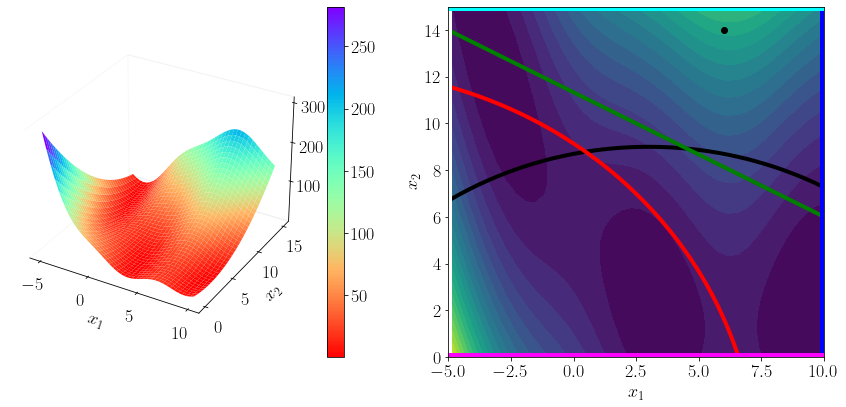

In [3]:
# plot branin
m = 40
xv, yv = np.meshgrid(np.linspace(-5,10, m), np.linspace(0,15,m))
x = np.column_stack((xv.reshape(-1,1), yv.reshape(-1,1)))

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection='3d')
sp = ax.plot_surface(xv, yv, branin(x).reshape(m,m), cmap=cm.rainbow_r,
                       linewidth=1,)
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
plt.colorbar(sp)

ax2 = fig.add_subplot(122)
cp  = ax2.contourf(xv,yv,branin(x).reshape(m,m), levels=25)
cp1 = ax2.contour(xv,yv,c1(x).reshape(m,m), levels=[0.], linewidths=4, colors='k')
cp2 = ax2.contour(xv,yv,c2(x).reshape(m,m), levels=[0.], linewidths=4, colors='r')
cp3 = ax2.contour(xv,yv,c3(x).reshape(m,m), levels=[0.], linewidths=4, colors='g')
cp4 = ax2.contour(xv,yv,c4(x).reshape(m,m), levels=[0.], linewidths=8, colors='b')
cp5 = ax2.contour(xv,yv,c5(x).reshape(m,m), levels=[0.], linewidths=8, colors='w')
cp6 = ax2.contour(xv,yv,c6(x).reshape(m,m), levels=[0.], linewidths=8, colors='magenta')
cp7 = ax2.contour(xv,yv,c7(x).reshape(m,m), levels=[0.], linewidths=8, colors='aqua')

ax2.plot([6.], [14.], marker='o', c='k')
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')

plt.tight_layout()

## Problem 1 Penalty methods

In [4]:
class Step_Length():
    '''
    Class that implements backtracking to find a step length satisfying strong Wolfe
    condition.
    
    This is an exact replication of algorithms 3.5 and 3.6 in the textbook.
    
    Usage:
          sl = Step_Length(func, xk, pk)
          alpha = sl.line_search()
          
          Required arguments
          func: is a callable that takes x and returns f(x)
          xk: current iterate
          pk: current search direction
          
          Optional arguments
          c1: sufficient decrease (first Wolfe parameter) <default: 1e-4>
          c2: curvature condition (second Wolfe parameter) <default: 0.9>
          alphamax: maximum step length; passed to line_search() <default: 15.>
          alpha0: starting step length; passed to line_search() <default: 0.>
    '''
    def __init__(self, func, xk, pk, c1=1e-4, c2=0.9):
        self.func = func
        self.xk = xk
        self.pk = pk
        self.c1 = c1
        self.c2 = c2
        self.ncalls = 0


    def phi(self, alpha):
        return self.func(self.xk + alpha * self.pk)

    def phi_prime(self, alpha):
        return np.dot( np.asarray(grad(self.func)((self.xk + alpha * self.pk).squeeze())),
                      self.pk)

    def line_search(self, alphamax=15., alpha0=0.00):
        i      = 0
        strong_wolfe = False
        alphai = np.random.uniform(low=alpha0, high=alphamax)
        alphai_1 = alpha0
        phi_0 = self.phi(0.)
        self.ncalls += 1
        phi_alphai_1 = -np.inf
        
        while ~strong_wolfe and i < 100:
#             print(f'alphai {alphai}')
            phi_alphai   = self.phi(alphai)
            self.ncalls += 1
            if phi_alphai > phi_0 + self.c1 * alphai * self.phi_prime(0) or (phi_alphai >= phi_alphai_1 and i> 0):
                alpha = self.zoom(alphai_1, alphai)
                return alpha
            d_phiai = self.phi_prime(alphai)
            if np.abs(d_phiai) >= -self.c2 * self.phi_prime(0):
                return alphai
            if d_phiai >= 0:
                alpha = self.zoom(alphai, alphai_1)
                return alpha
            alphai_1 = alphai
            alphai = np.random.uniform(low=alphai, high=alphamax)
            phi_alphai_1   = self.phi(alphai_1)
            self.ncalls += 1
            i += 1
        return

    def zoom(self, alpha1, alpha2, c1=1e-4, c2=0.9):
        strong_wolfe = False
        iters = 0
        while ~strong_wolfe and iters < 25:
            alphaj = np.maximum(1e-8, 0.5 * (alpha1 + alpha2)) # bisection
            phi_alphaj = self.phi(alphaj)
            self.ncalls += 1
            phi_0   = self.phi(0.)
            self.ncalls += 1
            if phi_alphaj > phi_0 + self.c1 * alphaj * self.phi_prime(0) or phi_alphaj >= self.phi(alpha1):
                self.ncalls += 1
                alpha2 = alphaj
            else:
                d_phiaj = self.phi_prime(alphaj)
                if np.abs(d_phiaj) <= -self.c2 * self.phi_prime(0):
                    return alphaj
                if d_phiaj * (alpha2 - alpha1) >= 0:
                    alpha2 = alpha1
                    alpha1 = alphaj
            iters += 1
        return  alphaj

### Define a line search loop with nonlinear CG method

In [12]:
def linesearch_loop(x0, tauk, func, bounds, disp_iter=False):
    g_inf = 10
    eps   = tauk
    k     = 0
    xk    = x0 
    func  = func
    bounds= bounds
    fk    = func(xk)
    ginf_fr = []
    xk_fr   = []

    np.set_printoptions(precision=3)
    print(f'starting point x0: {xk}, f0: {fk}')
    print('----------------------------------')
    fres = 10

    gk = np.asarray( grad(func)(xk.squeeze()) )
    pk = -gk
    ncalls = 1
    while g_inf >= eps and k < 100: # included the second condition just for convenience; feel free to remove it
        fres = -fk
        sl = Step_Length(func, xk, pk)
        alpha = sl.line_search()
        xk_1 = xk + alpha * pk
        xk_1 = project_x(xk_1, bounds)
        gk_1 = np.asarray(grad(func)(xk_1.squeeze()) )
        # betak_1 = np.dot(gk_1, gk_1) / np.dot(gk, gk)
        # betak_1 = np.dot(gk_1, gk_1 - gk) / np.dot(gk, gk)
        betak_1 = np.dot(gk_1, gk_1 - gk) / np.maximum(1e-3, np.dot(gk_1 - gk, pk) )        
        pk_1 = -gk_1 + betak_1 * pk
        fk = func(xk_1)    
        fres = fk + fres
        g_inf = np.linalg.norm(gk_1, ord=np.inf)
        xk = xk_1
        gk = gk_1
        pk = pk_1    
        k += 1
        if disp_iter:
            print(f'iteration {k}, nfcalls: {ncalls + 1}, alpha: {alpha:1.7f}, xk: {xk.squeeze()}, fk: {fk.item():2.6f}, gradient norm: {g_inf:2.6f}')
        ginf_fr.append(g_inf)
        xk_fr.append(xk)
    print('----------------------------------')
    return xk, np.array(ginf_fr)

### Quadratic penalty

In [13]:
mu0 = 0.001
eta = 0.5
rho = 2.
tau0= 1.
x0 = np.array([6., 14.])
xk_array = [x0]
gfp_array = []
bounds_branin = np.array([[-5., 0], [10., 15.]])
project_x = lambda x, bounds=bounds_branin: np.maximum(np.minimum(x, bounds[1]), bounds[0])

tauk = tau0
muk  = mu0
while tauk > 1e-4 or muk < 10:
    f_penalized = lambda x: branin(x) + 0.5 * muk * c3(x)**2
    xk, ginf_fr = linesearch_loop(x0, tauk, f_penalized, bounds_branin, disp_iter=True)
    x0 = xk # starting points for next iteration
    muk = muk * rho
    tauk= tauk* eta
    xk_array.append(xk)
    gfp_array.append(ginf_fr)

starting point x0: [ 6. 14.], f0: 185.6554412841797
----------------------------------
iteration 1, nfcalls: 2, alpha: 0.4220657, xk: [4.413 3.103], fk: 9.822404, gradient norm: 10.617872
iteration 2, nfcalls: 2, alpha: 0.1145607, xk: [3.196 2.734], fk: 0.747165, gradient norm: 1.278948
iteration 3, nfcalls: 2, alpha: 0.7829116, xk: [3.299 2.303], fk: 0.630986, gradient norm: 1.707839
iteration 4, nfcalls: 2, alpha: 0.1550215, xk: [3.059 2.158], fk: 0.564332, gradient norm: 1.102091
iteration 5, nfcalls: 2, alpha: 0.0000001, xk: [3.059 2.158], fk: 0.564332, gradient norm: 1.102091
iteration 6, nfcalls: 2, alpha: 0.1472547, xk: [3.221 2.215], fk: 0.524405, gradient norm: 0.750145
----------------------------------
starting point x0: [3.221 2.215], f0: 0.6206639409065247
----------------------------------
iteration 1, nfcalls: 2, alpha: 0.0996245, xk: [3.148 2.22 ], fk: 0.594865, gradient norm: 0.152223
----------------------------------
starting point x0: [3.148 2.22 ], f0: 0.7891682386

### Plot

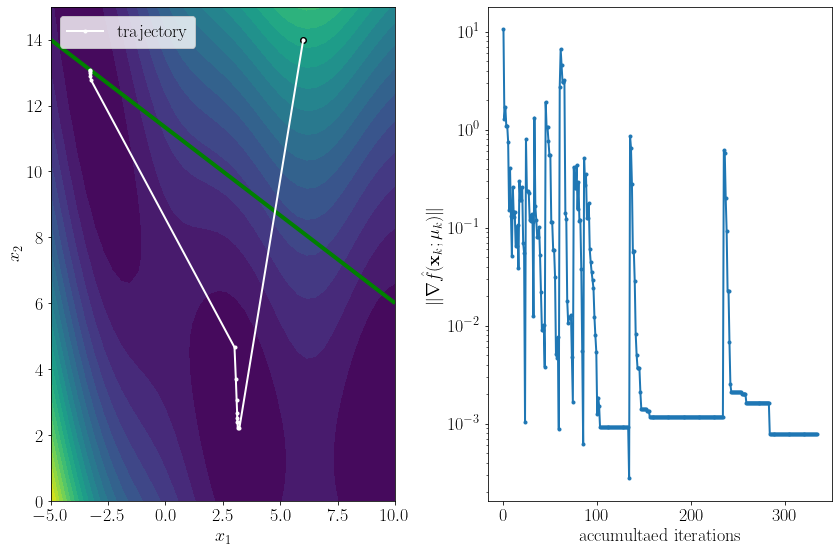

In [14]:
# plot branin
m = 40
xv, yv = np.meshgrid(np.linspace(-5,10, m), np.linspace(0,15,m))
x = np.column_stack((xv.reshape(-1,1), yv.reshape(-1,1)))
xk_ = np.array(xk_array)

fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(121)
cp  = ax2.contourf(xv,yv,branin(x).reshape(m,m), levels=25)
cp3 = ax2.contour(xv,yv,c3(x).reshape(m,m), levels=[0.], linewidths=4, colors='g')
ax2.plot([6.], [14.], marker='o', c='k')
ax2.plot(xk_[:,0], xk_[:,1], c='w', marker='.', label='trajectory')
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')
ax2.legend()

gfp = np.concatenate(gfp_array)
ax1 = fig.add_subplot(122)
ax1.semilogy(np.arange(gfp.shape[0]), gfp, marker='.', lw=2)
ax1.set_xlabel('accumultaed iterations')
ax1.set_ylabel(r'$\| \nabla \hat{f}(\mathbf{x}_k; \mu_k)\|$')
plt.tight_layout()

 - Notice how the iterates violate the constraint initially, due to smaller values of $\mu_k$ and then eventually finds the constraint boundary. 
 - On the right, notice that we converge successively to a smaller threshold as the penalty parameter $\mu_k$ increases.
 - Note that each repetition of this algorithm could show a different history plot (to the right). What is more important is that the trajectory converges to the KKT point as shown in the left.

### Augmented Lagrangian

In [15]:
mu0 = 0.001
eta = 0.5
rho = 2.
tau0= 1.
lambdak = 0.
x0 = np.array([6., 14.])
xk_array = [x0]
gfp_array = []
bounds_branin = np.array([[-5., 0], [10., 15.]])
project_x = lambda x, bounds=bounds_branin: np.maximum(np.minimum(x, bounds[1]), bounds[0])

tauk = tau0
muk  = mu0
while tauk > 1e-4 or muk < 10:
    lambdak = lambdak - muk * c3(xk)
    f_penalized = lambda x: branin(x) + 0.5 * muk * c3(x)**2 - lambdak * c3(x)
    xk, ginf_fr = linesearch_loop(x0, tauk, f_penalized, bounds_branin, disp_iter=True)
    x0 = xk # starting points for next iteration
    muk = muk * rho
    tauk= tauk* eta
    xk_array.append(xk)
    gfp_array.append(ginf_fr)

starting point x0: [ 6. 14.], f0: 185.6548614501953
----------------------------------
iteration 1, nfcalls: 2, alpha: 0.4510944, xk: [4.304 2.354], fk: 6.920847, gradient norm: 9.576450
iteration 2, nfcalls: 2, alpha: 0.1346461, xk: [3.    2.041], fk: 0.719291, gradient norm: 1.936005
iteration 3, nfcalls: 2, alpha: 1.3267940, xk: [2.935 2.366], fk: 0.705768, gradient norm: 2.114646
iteration 4, nfcalls: 2, alpha: 0.0914134, xk: [3.119 2.426], fk: 0.511149, gradient norm: 0.241721
----------------------------------
starting point x0: [3.119 2.426], f0: 0.9722996950149536
----------------------------------
iteration 1, nfcalls: 2, alpha: 0.9086532, xk: [3.175 2.276], fk: 0.970395, gradient norm: 0.307803
----------------------------------
starting point x0: [3.175 2.276], f0: 1.9235917329788208
----------------------------------
iteration 1, nfcalls: 2, alpha: 0.3141179, xk: [3.104 2.34 ], fk: 1.918639, gradient norm: 0.438114
iteration 2, nfcalls: 2, alpha: 0.2316584, xk: [3.108 2.472

### Plot

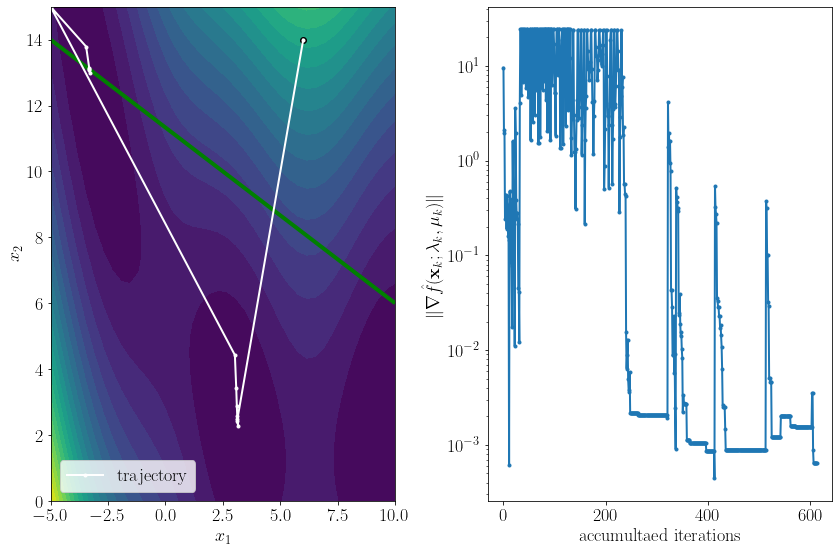

In [16]:
# plot branin
m = 40
xv, yv = np.meshgrid(np.linspace(-5,10, m), np.linspace(0,15,m))
x = np.column_stack((xv.reshape(-1,1), yv.reshape(-1,1)))
xk_ = np.array(xk_array)

fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(121)
cp  = ax2.contourf(xv,yv,branin(x).reshape(m,m), levels=25)
cp3 = ax2.contour(xv,yv,c3(x).reshape(m,m), levels=[0.], linewidths=4, colors='g')
ax2.plot([6.], [14.], marker='o', c='k')
ax2.plot(xk_[:,0], xk_[:,1], c='w', marker='.', label='trajectory')
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')
ax2.legend()

gfp = np.concatenate(gfp_array)
ax1 = fig.add_subplot(122)
ax1.semilogy(np.arange(gfp.shape[0]), gfp, marker='.', lw=2)
ax1.set_xlabel('accumultaed iterations')
ax1.set_ylabel(r'$\| \nabla \hat{f}(\mathbf{x}_k; \lambda_k, \mu_k)\|$')
plt.tight_layout()

 - Notice how the iterates violate the constraint initially, due to smaller values of $\mu_k$ and then eventually finds the constraint boundary. 
 - On the right, notice that we converge successively to a smaller threshold as the penalty parameter $\mu_k$ increases.
 - Note that each repetition of this algorithm could show a different history plot (to the right). What is more important is that the trajectory converges to the KKT point as shown in the left.

## Problem 2 - active set method

In [17]:
f   = lambda x: (x[...,0]**2 + 2*x[...,1]**2 - 2*x[...,0] -6*x[...,1] -2*x[...,0]*x[...,1]).squeeze()
c_1 = lambda x: (.5*x[...,0] + .5*x[...,1] - 1).squeeze()
c_2 = lambda x: (-x[...,0] + 1.5*x[...,1] - 2).squeeze()
c_3 = lambda x: (x[...,0]).squeeze()
c_4 = lambda x: (x[...,1]).squeeze()
c = [c_1, c_2, c_3, c_4]
d = np.array([-1., -2., 0., 0.]) # RHS of constraint equations

In [18]:
m  = len(c)
n  = 2
xk = np.array([[3., 2.]]) # starting point
Bk = hessian(f)(xk).squeeze() # function hessian
Ck = np.concatenate([grad(c[i])(xk) for i in range(m)]) # note (upper case) Ck has *gradients* of all constraints at xk
ck = np.concatenate([[c[i](xk)] for i in range(m)]) # note (lower case) ck has *value* of all constraints at xk

In [19]:
def get_active_set(ck, xk):
    Wk = []
    # find which constraints are active
    for i in range(m):
        if np.abs(ck[i]) <= 1e-8:
            Wk.append(i)
    return Wk

def construct_kkt_and_solve(xk, Bk, Ck, Wk, f, c):
    n_active = len(Wk)
    m    = len(c)
    lk_I = np.zeros(m) # Lagrange multipliers for all inequality constraints
    Z    = np.zeros([n_active, n_active])
    
    if n_active > 0:
        L = np.block([[Bk, -Ck[Wk].T],
                      [-Ck[Wk], Z]])
    else:
        L = Bk # no active constraints

    y    = np.append(-grad(f)(xk).squeeze() + np.matmul(Ck[Wk].T, lk_I[Wk]), np.zeros(n_active) )
    soln = np.linalg.solve(L, y)
    pk   = soln[:n]

    if n_active > 0:
        lk_I[Wk] = soln[-n_active:]
    
    return pk, lk_I

def update_lagrange_multipliers(lk_I, Wk):
    m    = lk_I.shape[0]
    mask = np.full(m, True, dtype=bool)
    mask[Wk]  = False # identify inactive constraints
    I_k       = np.arange(m)[mask]
    lk_I[I_k] = np.zeros_like(I_k)
    return lk_I

def get_blocking_constraints(Ck, pk):
    m = Ck.shape[0]
    cTp = []
    for i in range(m):
        cTp.append(np.dot(Ck[i], pk))
    blocking_ind = np.arange(m)[np.array(cTp) < -1e-12]
    # print(f'dot(c,p) {cTp} blocking constraints {blocking_ind}, {blocking_ind.shape}')
    return blocking_ind

def get_steplengths(blocking_ind, Ck, d, pk):
    m = Ck.shape[0]
    a = np.zeros(m)
    for i in blocking_ind:
        a[i] = -(np.dot(Ck[i],xk.squeeze()) + d[i]) / np.dot(Ck[i], pk) 
        # print(f'alpha_{i+1} = {a[i]}')
    ak = min(1, min(a[blocking_ind]))
    return ak

def remove_negative_lambda_constraints(lk_I, Wk):
    removed = False
    m = lk_I.shape[0]
    if any(lk_I < 0):
        print('negative Lagrange parameters, remove one of them from working set')
        negative_l_inds = np.arange(m)[lk_I < 0]
        if len(lk_I[negative_l_inds]) == 0:
            print('all Lagrange parameters are nonnegative')
        elif len(lk_I[negative_l_inds]) == 1:
            Wk.remove(negative_l_inds)
            removed = True
        else:
            Wk.remove(lk_I.argmin())
            removed = True
    else:
        print(f'Lagrange multipliers are all nonnegative!!')
    return Wk, removed

In [20]:
xk    = np.array([[6., 14.]]) # starting point
pkinf = 10
eps   = 1e-10
m     = len(c)
lk_I    = np.zeros(m)
removed = False
k     = 0
ak    = 0.

xk_array_as = [xk]
lagrangian_grad = []
lagrangian_gradinf = []

while (pkinf > eps or any(lk_I < 0)) and k < 100:

    Bk = hessian(f)(xk).squeeze() # function hessian
    Ck = np.concatenate([grad(c[i])(xk) for i in range(m)]) # gradients of each constraint
    ck = np.concatenate([[c[i](xk)] for i in range(m)]) # value of each constraint
    if ~removed:
        Wk          = get_active_set(ck, xk) 
    pk, lk_I    = construct_kkt_and_solve(xk, Bk, Ck, Wk, f, c)
    pkinf = np.linalg.norm(pk, np.inf)
    # print(f'Working set {Wk}, pk {pk}, Lagrange multipliers {lk_I}')
    
    if pkinf < eps:
        print(f'pk=0, potential convergence.')
        # check for Lagrange parameter sign
        Wk, removed = remove_negative_lambda_constraints(lk_I, Wk)
        pk, lk_I    = construct_kkt_and_solve(xk, Bk, Ck, Wk, f, c)
        lk_I        = update_lagrange_multipliers(lk_I, Wk)
        pkinf = np.linalg.norm(pk, np.inf)

    blocking_ind= get_blocking_constraints(Ck, pk)
    if blocking_ind.shape[0] > 0:
        ak = get_steplengths(blocking_ind, Ck, d, pk)
        # print(f'chosen step length alpha_k {ak}')
        xk = xk + ak * pk
        # print(f'pk {pk}, new point xk {xk}')
        removed = False
    k += 1
    xk_array_as.append(xk)
    lagrangian_grad.append(grad(f)(xk) - np.matmul(Ck.T, lk_I))
    lagrangian_gradinf.append(np.linalg.norm(grad(f)(xk) - np.matmul(Ck.T, lk_I), np.inf) )
    
    print(f'iter {k}, Working set {Wk}, pk {pk}, step length {ak}, new point {xk}, Lagrange multipliers {lk_I}')

print('-------------------------------')
print(f'constrained minimizer {xk}, constrained minimum {f(xk)}, Lagrange multipliers {lk_I}')

iter 1, Working set [], pk [ -1. -10.], step length 0.9285714285714286, new point [[5.071 4.714]], Lagrange multipliers [0. 0. 0. 0.]
iter 2, Working set [1], pk [-0.471 -0.314], step length 1, new point [[4.6 4.4]], Lagrange multipliers [0.  1.6 0.  0. ]
iter 3, Working set [1], pk [5.722e-07 3.815e-07], step length 1, new point [[4.6 4.4]], Lagrange multipliers [0.  1.6 0.  0. ]
iter 4, Working set [1], pk [5.722e-07 3.815e-07], step length 1, new point [[4.6 4.4]], Lagrange multipliers [0.  1.6 0.  0. ]
iter 5, Working set [1], pk [5.722e-07 3.815e-07], step length 1, new point [[4.6 4.4]], Lagrange multipliers [0.  1.6 0.  0. ]
iter 6, Working set [1], pk [5.722e-07 3.815e-07], step length 1, new point [[4.6 4.4]], Lagrange multipliers [0.  1.6 0.  0. ]
iter 7, Working set [1], pk [5.722e-07 3.815e-07], step length 1, new point [[4.6 4.4]], Lagrange multipliers [0.  1.6 0.  0. ]
iter 8, Working set [1], pk [5.722e-07 3.815e-07], step length 1, new point [[4.6 4.4]], Lagrange multip

### Plot

<ipython-input-21-267ba8fb9314>:14: UserWarning: No contour levels were found within the data range.
  cp4 = ax2.contour(xv,yv,c_4(x).reshape(m,m), levels=[0.], linewidths=8, colors='b')


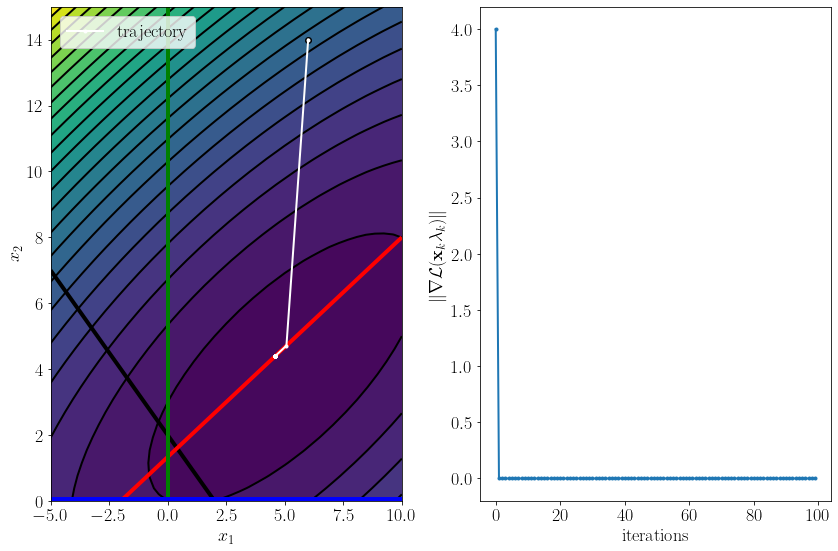

In [21]:
# plot branin
m = 40
xv, yv = np.meshgrid(np.linspace(-5,10, m), np.linspace(0,15,m))
x = np.column_stack((xv.reshape(-1,1), yv.reshape(-1,1)))
xk_ = np.array(xk_array_as).squeeze()

fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(121)
cp  = ax2.contourf(xv,yv,f(x).reshape(m,m), levels=25)
cp  = ax2.contour(xv,yv,f(x).reshape(m,m), levels=25, linestyles='-', colors='k')
cp1 = ax2.contour(xv,yv,c_1(x).reshape(m,m), levels=[0.], linewidths=4, colors='k')
cp2 = ax2.contour(xv,yv,c_2(x).reshape(m,m), levels=[0.], linewidths=4, colors='r')
cp3 = ax2.contour(xv,yv,c_3(x).reshape(m,m), levels=[0.], linewidths=4, colors='g')
cp4 = ax2.contour(xv,yv,c_4(x).reshape(m,m), levels=[0.], linewidths=8, colors='b')
ax2.plot([6.], [14.], marker='o', c='k')
ax2.plot(xk_[:,0], xk_[:,1], c='w', marker='.', label='trajectory')
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')
ax2.legend()

gfp = np.array(lagrangian_gradinf)
ax1 = fig.add_subplot(122)
ax1.plot(np.arange(gfp.shape[0]), gfp, marker='.', lw=2)
ax1.set_xlabel('iterations')
ax1.set_ylabel(r'$\| \nabla \mathcal{L}(\mathbf{x}_k \lambda_k)\|$')
plt.tight_layout()

## Problem 3 - Linesearch SQP

### Let's redefine our objective and constraints

In [22]:
f  = lambda x: jnp.asarray( (x[...,1] - 5.1/4/jnp.pi**2 * x[...,0]**2 + 5/jnp.pi * x[...,0] - 6)**2 + 10*(1 - 1/8/jnp.pi)*jnp.cos(x[...,0]) + 10).squeeze()
c1 = lambda x: ((x[...,0] - 3.)**2 + (x[...,1] +6.)**2 - 225).squeeze()
c2 = lambda x: ((x[...,0] + 10.)**2 + (x[...,1] +5.)**2 - 300).squeeze()
c3 = lambda x: (x[...,0] + (15/8) *  x[...,1] - (85/4)).squeeze()
c4 = lambda x: (-x[...,0] + 10.).squeeze()
c5 = lambda x: ( x[...,0] + 5. ).squeeze()
c6 = lambda x: (x[...,1]).squeeze()
c7 = lambda x: (-x[...,1] + 15.).squeeze()
c = [c1, c2, c3, c4, c5, c6, c7]
d = np.array([-225., -300., -85./4., 10., 5., 0., 15.]) # RHS of constraint equations To be overridden inside loop for c1 and c2 since they are nonlinear

m = len(c)
E = [2]
I = list(range(0,m))
I.pop(E[0])

2

### Damped BFGS update

In [23]:
def damped_bfgs(Bk, yk, sk):
    thetak = 1.                                              # default value (no damping)
    sk_yk = np.dot(sk, yk)                                   # predicted curvature
    sk_Bk_sk = np.dot(sk, np.matmul(Bk, sk.reshape(-1,1)) )  # actual curvature
    if sk_yk < 0.2 * sk_Bk_sk: 
        thetak = 0.8 * sk_Bk_sk / (sk_Bk_sk - sk_yk)         # damping coefficient

    rk = thetak * yk + (1 - thetak) * np.matmul(Bk, sk)
    
    Bk = Bk - np.matmul(Bk, np.matmul(np.outer(sk,sk), Bk) )/sk_Bk_sk + np.outer(rk, rk)/(np.dot(sk, rk) + 1e-8) # damped BFGS update
    return Bk, thetak

### Linesearch SQP loop

In [24]:
xk    = np.array([[6., 14.]]) # starting point
pkinf = 10
gLkinf= 10
eps   = 1e-6
m     = len(c)
lk_I  = np.zeros(m)
removed = False
k     = 0
ak    = 0.

eta   = 0.4
tau   = 0.5
Bk    = np.eye(n) * 0.1 # initial guess Hessian

ck_ = lambda xk, c=c: np.concatenate([[c[i](xk)] for i in range(m)])

def cktilde_1norm(xk, alphak, pk):
    '''
    This function computes the overall 1-norm of constraint violation
    at every iteration.
    '''
    ck = ck_(xk + alphak * pk)
    ck_tilde = np.maximum(0, -ck)
    ck_tilde[E] = ck[E]
    return np.linalg.norm(ck_tilde, 1)

print(f'starting point x0 {xk}, f0 {f(xk)}')
print(f'----------------------------------')
mu0 = 0.6 # merit parameter
rho = 0.1 # for sufficient decrease condition
b   = 1.2 # factor to increase mu0
    
x_hist = [xk]

cons_viol = 10

while gLkinf > eps and k<55:

    # KKT system    
    Ck = np.concatenate([grad(c[i])(xk) for i in range(m)]) # gradients of each constraint
    ck = np.concatenate([[c[i](xk)] for i in range(m)]) # value of each constraint
    d[0] = c1(xk)
    d[1] = c2(xk)
    
    Wk       = get_active_set(ck, xk) 
    pk, lk_I_= construct_kkt_and_solve(xk, Bk, Ck, Wk, f, c)
    pk = pk / np.linalg.norm(pk, 2)
    pkinf = np.linalg.norm(pk, np.inf)
    plambda = lk_I_ - lk_I
    
    # choose mu_k
    mu0 = mu0 * b
    muk = max(mu0, (np.dot(grad(f)(xk), pk) + .5* np.dot(pk, np.matmul(Bk, pk)) ) / ((1-rho) * cktilde_1norm(xk, 0., pk)) ) 
    
    # choose step length alphak
    phi1  = lambda xk, alphak, muk: f(xk + alphak*pk) + muk * cktilde_1norm(xk, alphak, pk) # merit function
    Dphi1 = lambda xk, pk, muk: np.dot(grad(f)(xk), pk) - muk * cktilde_1norm(xk, 0., pk)   # directional derivative
    alphak = 10 # starting step length
    while phi1(xk, alphak, muk) > phi1(xk, 0., muk) + eta * alphak * Dphi1(xk, pk, muk):
        # print(f'directional derivative {Dphi1(xk, pk, muk)}')
        alphak = alphak * tau
    
    # update step
    xk = xk + alphak * pk
    
    x_hist.append(xk)

    lk_I_ = lk_I + alphak * plambda
    gLk = grad(f)(xk).squeeze() - np.matmul(Ck.T, lk_I_.reshape(-1,1)).squeeze()
    gLkinf = np.linalg.norm(gLk, np.inf)
        
    # Hessian update
    sk = alphak*pk
    yk = grad(f)(xk ).squeeze() - np.matmul(Ck.T, lk_I_.reshape(-1,1)).squeeze()  - grad(f)(xk - alphak * pk).squeeze() + np.matmul(Ck.T, lk_I.reshape(-1,1)).squeeze() # Lagrange  
    Bk, thetak = damped_bfgs(Bk, yk.squeeze(), sk)    

    lk_I = lk_I_ 
    
    k += 1
    
    print(f'iter {k}, Working set {Wk}, muk {muk}, gLkinf {gLkinf}, cons viol {cktilde_1norm(xk, 0., pk)}, pk {pk}, step length {alphak}, new point {xk}, Lagrange multipliers {lk_I}')
    # break

print('-------------------------------')
print(f'constrained minimizer {xk}, constrained minimum {f(xk)}, Lagrange multipliers {lk_I_}')

starting point x0 [[ 6. 14.]], f0 185.59494018554688
----------------------------------
iter 1, Working set [], muk 0.72, gLkinf 15.708211898803711, cons viol 1.0033403486882833, pk [-0.144 -0.99 ], step length 5.0, new point [[5.281 9.052]], Lagrange multipliers [0. 0. 0. 0. 0. 0. 0.]
iter 2, Working set [], muk 0.864, gLkinf 14.729862213134766, cons viol 7.133259861946566, pk [-0.777 -0.63 ], step length 0.625, new point [[4.796 8.658]], Lagrange multipliers [0. 0. 0. 0. 0. 0. 0.]
iter 3, Working set [], muk 1.0368, gLkinf 14.729864120483398, cons viol 7.133266675905702, pk [-0.787 -0.617], step length 2.980232238769531e-07, new point [[4.796 8.658]], Lagrange multipliers [0. 0. 0. 0. 0. 0. 0.]
iter 4, Working set [], muk 1.24416, gLkinf 14.729864120483398, cons viol 7.133273489864699, pk [-0.787 -0.617], step length 2.980232238769531e-07, new point [[4.796 8.658]], Lagrange multipliers [0. 0. 0. 0. 0. 0. 0.]
iter 5, Working set [], muk [3.213], gLkinf 15.695068359375, cons viol 0.99

<ipython-input-25-ab18b6ea63b5>:15: UserWarning: No contour levels were found within the data range.
  cp4 = ax.contour(xv,yv,c4(x).reshape(m,m), levels=[0.], linewidths=8, colors='b')
<ipython-input-25-ab18b6ea63b5>:16: UserWarning: No contour levels were found within the data range.
  cp5 = ax.contour(xv,yv,c5(x).reshape(m,m), levels=[0.], linewidths=8, colors='w')
<ipython-input-25-ab18b6ea63b5>:17: UserWarning: No contour levels were found within the data range.
  cp6 = ax.contour(xv,yv,c6(x).reshape(m,m), levels=[0.], linewidths=8, colors='magenta')
<ipython-input-25-ab18b6ea63b5>:18: UserWarning: No contour levels were found within the data range.
  cp7 = ax.contour(xv,yv,c7(x).reshape(m,m), levels=[0.], linewidths=8, colors='aqua')


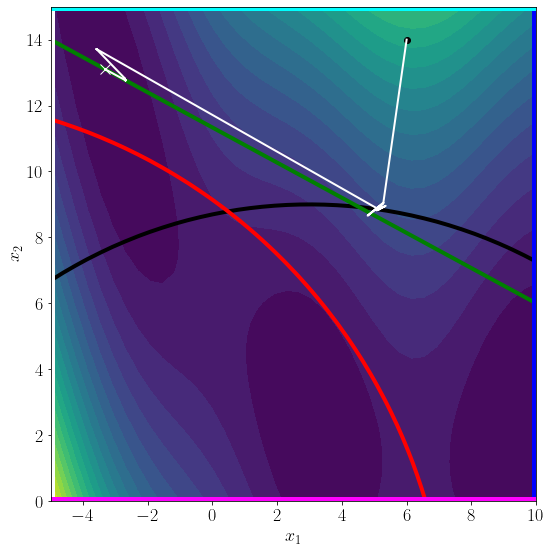

In [25]:
from matplotlib import cm

# plot branin
m = 40
xv, yv = np.meshgrid(np.linspace(-5,10, m), np.linspace(0,15,m))
x = np.column_stack((xv.reshape(-1,1), yv.reshape(-1,1)))

fig = plt.figure(figsize=(8,8))

ax  = fig.add_subplot(111)
cp  = ax.contourf(xv,yv,f(x).reshape(m,m), levels=25)
cp1 = ax.contour(xv,yv,c1(x).reshape(m,m), levels=[0.], linewidths=4, colors='k')
cp2 = ax.contour(xv,yv,c2(x).reshape(m,m), levels=[0.], linewidths=4, colors='r')
cp3 = ax.contour(xv,yv,c3(x).reshape(m,m), levels=[0.], linewidths=4, colors='g')
cp4 = ax.contour(xv,yv,c4(x).reshape(m,m), levels=[0.], linewidths=8, colors='b')
cp5 = ax.contour(xv,yv,c5(x).reshape(m,m), levels=[0.], linewidths=8, colors='w')
cp6 = ax.contour(xv,yv,c6(x).reshape(m,m), levels=[0.], linewidths=8, colors='magenta')
cp7 = ax.contour(xv,yv,c7(x).reshape(m,m), levels=[0.], linewidths=8, colors='aqua')

ax.plot([6.], [14.], marker='o', c='k')
x = np.array(x_hist).squeeze()
ax.plot(x[:,0], x[:,1], c='w')
ax.plot(x[-1,0], x[-1,1], marker='x', c='w', markersize=10)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

plt.tight_layout()